In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.base import clone
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

file_name = "CDC_Wastewater_Data_for_Influenza_A.csv"
df = pd.read_csv(file_name, low_memory=False)

print("Veri Temizliğine ve Özellik Mühendisliğine Başlanıyor")

Veri Temizliğine ve Özellik Mühendisliğine Başlanıyor


In [68]:
# Veri Temizliği ve Özellik Mühendisliği

df['sample_collect_date'] = pd.to_datetime(df['sample_collect_date'], errors='coerce')
df['collection_month'] = df['sample_collect_date'].dt.month
df['collection_week'] = df['sample_collect_date'].dt.isocalendar().week.astype(int)
df['collection_dayofweek'] = df['sample_collect_date'].dt.dayofweek

df['flow_rate_missing'] = df['flow_rate'].isnull().astype(int)
flow_median = df['flow_rate'].median()
df['flow_rate'] = df['flow_rate'].fillna(flow_median)

df['pcr_target_flowpop_lin'] = df['pcr_target_flowpop_lin'].fillna(df['pcr_target_flowpop_lin'].median())
df['flowpop_lin_missing'] = df['pcr_target_flowpop_lin'].isnull().astype(int)

df['log_population_served'] = np.log1p(df['population_served'])
df['log_flow_rate'] = np.log1p(df['flow_rate'])

df['influenza_a_detected'] = (df['pcr_target_avg_conc'] > 0).astype(int)
df['log_pcr_target_conc'] = np.log1p(df['pcr_target_avg_conc'])

In [69]:
print("Şimdi verimize özellikler ekliyoruz")

df = df.sort_values(by=['wwtp_jurisdiction', 'sample_collect_date'])
df['log_conc_roll_avg_3'] = df.groupby('wwtp_jurisdiction')['log_pcr_target_conc'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['log_conc_roll_std_3'] = df.groupby('wwtp_jurisdiction')['log_pcr_target_conc'].transform(
    lambda x: x.rolling(3, min_periods=1).std()
)
df['log_conc_roll_std_3'] = df['log_conc_roll_std_3'].fillna(0)

bins = [0, 20000, 50000, 200000, np.inf]
labels = ['Small', 'Medium', 'Large', 'Very Large']

df['population_group'] = pd.cut(df['population_served'], bins=bins, labels=labels, right=False)
count_map = df[df['influenza_a_detected'] == 1].groupby('wwtp_jurisdiction').size()
df['jurisdiction_positive_count'] = df['wwtp_jurisdiction'].map(count_map)
df['jurisdiction_positive_count'] = df['jurisdiction_positive_count'].fillna(0)

Şimdi verimize özellikler ekliyoruz


In [70]:
columns_to_drop = [
    'inhibition_adjust', 'sample_id', 'date_updated', 'rec_eff_target_name', 
    'rec_eff_spike_matrix', 'rec_eff_spike_conc', 'hum_frac_mic_unit', 
    'pcr_target_mic_lin', 'hum_frac_mic_conc', 'hum_frac_target_mic',
    'ntc_amplify', 
    'pcr_target' 
]
df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

df['pasteurized'] = df['pasteurized'].fillna(df['pasteurized'].mode()[0])
df['counties_served'] = df['counties_served'].fillna(df['counties_served'].mode()[0])
df['lod_sewage'] = df['lod_sewage'].fillna(df['lod_sewage'].median())
df['pcr_gene_target_agg'] = df['pcr_gene_target_agg'].fillna(df['pcr_gene_target_agg'].mode()[0])
df['rec_eff_percent'] = np.clip(df['rec_eff_percent'], a_min=None, a_max=100) # Capping

df.drop_duplicates(inplace=True)

print("Adım (Encoding): 'population_group' (Small, Medium...) için 'population_group_encoded' (0, 1, 2...) sütunu ekleniyor...")
pop_kategorileri = pd.CategoricalDtype(
    categories=['Small', 'Medium', 'Large', 'Very Large'],
    ordered=True
)
df['population_group'] = df['population_group'].astype(pop_kategorileri)
df['population_group_encoded'] = df['population_group'].cat.codes

print("Adım (Yeni FE V3): Polinom Özellikler (Karesel) oluşturuluyor...")
df['log_pop_sq'] = df['log_population_served'] ** 2
df['log_flow_sq'] = df['log_flow_rate'] ** 2


print("Veri Temizliği ve Özellik Mühendisliği Tamamlandı")

Adım (Encoding): 'population_group' (Small, Medium...) için 'population_group_encoded' (0, 1, 2...) sütunu ekleniyor...
Adım (Yeni FE V3): Polinom Özellikler (Karesel) oluşturuluyor...
Veri Temizliği ve Özellik Mühendisliği Tamamlandı


Keşifsel Analizin (EDA) Ana Grafik Çıktıları ---


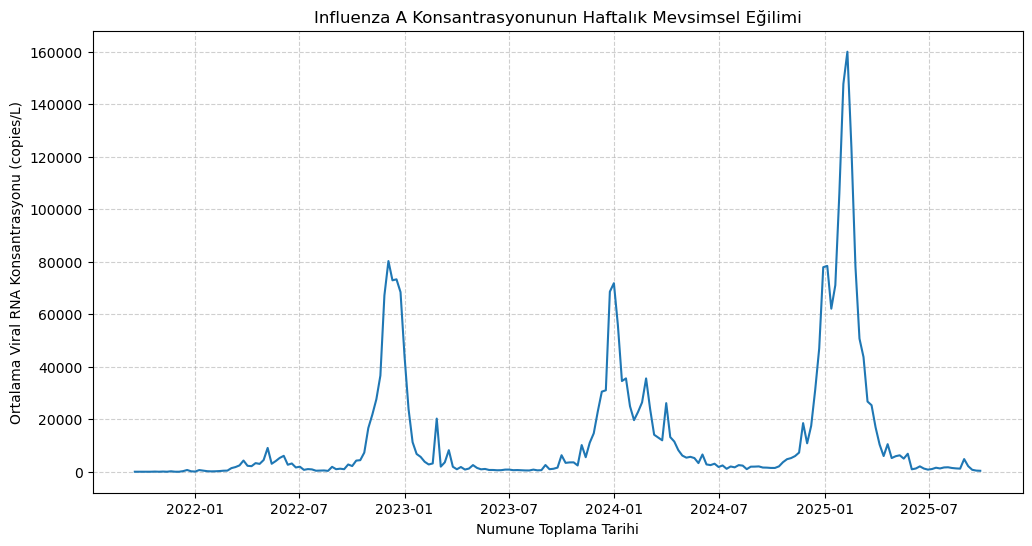

In [71]:
print("Keşifsel Analizin (EDA) Ana Grafik Çıktıları ---")

# 1. Standart Mevsimsel Eğilim (Zaman)
plt.figure(figsize=(12, 6))
weekly_avg = df.dropna(subset=['sample_collect_date']).set_index('sample_collect_date')['pcr_target_avg_conc'].resample('W').mean().reset_index()
sns.lineplot(data=weekly_avg, x='sample_collect_date', y='pcr_target_avg_conc')
plt.title('Influenza A Konsantrasyonunun Haftalık Mevsimsel Eğilimi')
plt.xlabel('Numune Toplama Tarihi')
plt.ylabel('Ortalama Viral RNA Konsantrasyonu (copies/L)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

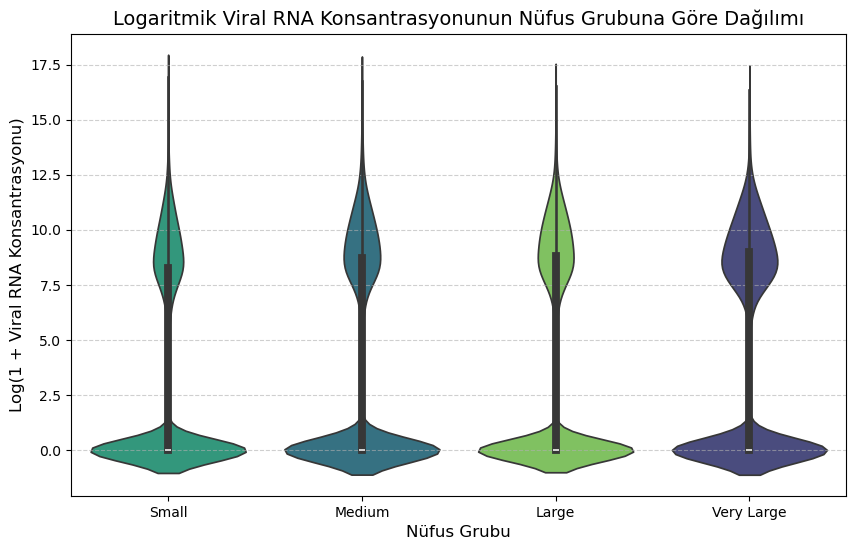

In [72]:
plt.figure(figsize=(10, 6))
sns.violinplot(
    x=df['population_group'].astype(str), y='log_pcr_target_conc', data=df,
    order=['Small', 'Medium', 'Large', 'Very Large'], palette='viridis',
    hue=df['population_group'].astype(str), legend=False
)
plt.title('Logaritmik Viral RNA Konsantrasyonunun Nüfus Grubuna Göre Dağılımı', fontsize=14)
plt.xlabel('Nüfus Grubu', fontsize=12)
plt.ylabel('Log(1 + Viral RNA Konsantrasyonu)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

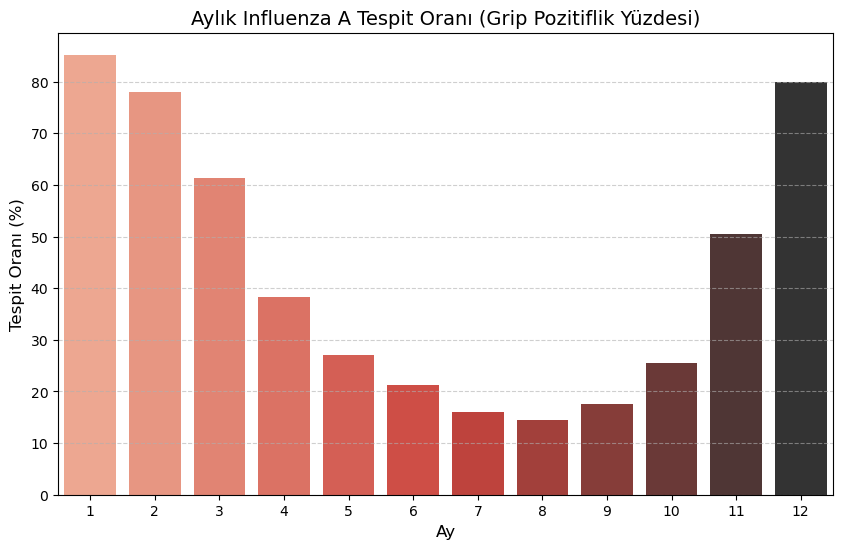

In [73]:
monthly_data = df.dropna(subset=['collection_month'])
monthly_total = monthly_data.groupby('collection_month').size().reset_index(name='total_samples')
monthly_detected = monthly_data[monthly_data['influenza_a_detected'] == 1].groupby('collection_month').size().reset_index(name='detected_samples')
monthly_detection_rate = pd.merge(monthly_total, monthly_detected, on='collection_month', how='left')
monthly_detection_rate['detected_samples'] = monthly_detection_rate['detected_samples'].fillna(0)
monthly_detection_rate['detection_rate'] = (monthly_detection_rate['detected_samples'] / monthly_total['total_samples']) * 100

plt.figure(figsize=(10, 6))
sns.barplot(
    x='collection_month', y='detection_rate', data=monthly_detection_rate,
    palette='Reds_d', hue='collection_month', legend=False
)
plt.title('Aylık Influenza A Tespit Oranı (Grip Pozitiflik Yüzdesi)', fontsize=14)
plt.xlabel('Ay', fontsize=12)
plt.ylabel('Tespit Oranı (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

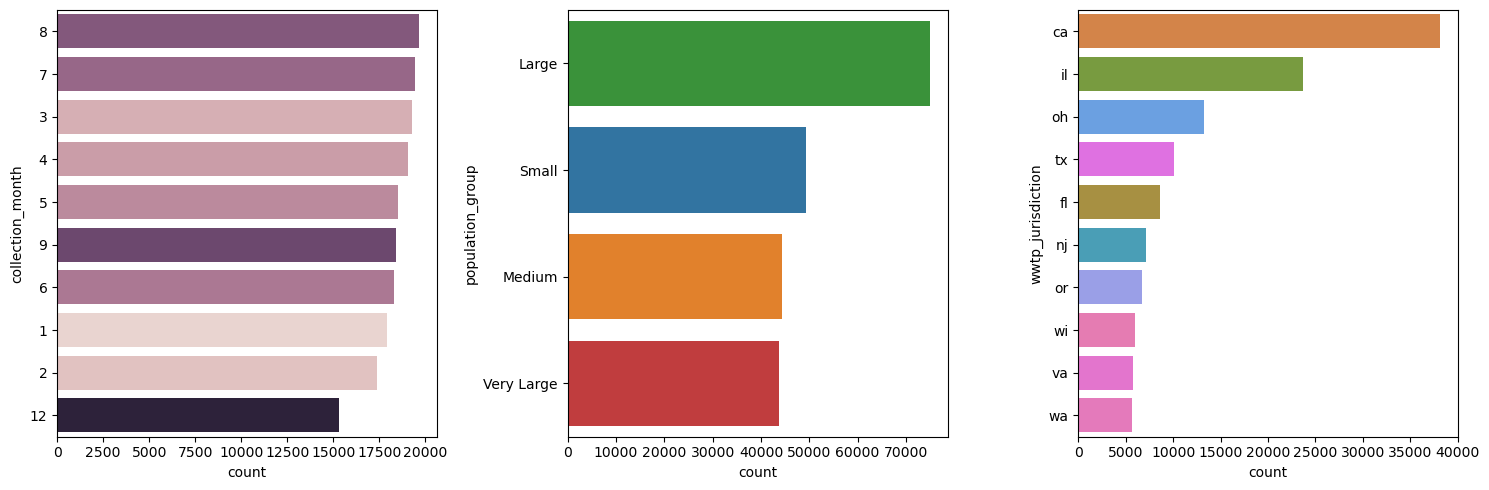

In [74]:
categorical_cols_for_plot = ['collection_month', 'population_group', 'wwtp_jurisdiction']
plt.figure(figsize=(15, 5))

for i, col in enumerate(categorical_cols_for_plot):
    plt.subplot(1, 3, i + 1)
    plot_data = df[col].dropna()
    sns.countplot(data=df, y=col, order=plot_data.value_counts().index[:10], hue=col, legend=False)
plt.tight_layout()
plt.show()

In [75]:
output_file_name = "temizlenmis_veri_seti.csv"
df.to_csv(output_file_name, index=False)
print(f"\nTemizlenmiş ve yeni özellikler içeren veri seti başarıyla kaydedildi: {output_file_name}")


Temizlenmiş ve yeni özellikler içeren veri seti başarıyla kaydedildi: temizlenmis_veri_seti.csv


In [76]:
# Model için Kullanılacak Feature Selection ve Veri Seti Hazırlanıyor
features = [
    'collection_month', 
    'collection_week', 
    'collection_dayofweek',

    
    'log_population_served', 'log_flow_rate', 'rec_eff_percent',
    'flow_rate_missing', 'flowpop_lin_missing',
    'population_group_encoded', 
    
    
    'log_conc_roll_avg_3',       
    'log_conc_roll_std_3',       
    'jurisdiction_positive_count', 
    'log_pop_sq',                
    'log_flow_sq'                
]

df_model = df.dropna(subset=features + ['influenza_a_detected'])

X = df_model[features]
y = df_model['influenza_a_detected'] 

print("\n Base Model Eğitimine Başlanılıyor:  ---")
print(f"Modelin Kullanacağı Toplam Özellik Sayısı: {X.shape[1]}")
print(f"Model Eğitimi İçin Kullanılan Toplam Satır Sayısı: {X.shape[0]}")
print(f"Positive/Negative Oranı: {y.mean():.3f}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


 Base Model Eğitimine Başlanılıyor:  ---
Modelin Kullanacağı Toplam Özellik Sayısı: 14
Model Eğitimi İçin Kullanılan Toplam Satır Sayısı: 212401
Positive/Negative Oranı: 0.420


In [77]:
# Kullanılan Modeller
base_models = {
    'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'KNeighborsClassifier': KNeighborsClassifier(n_neighbors=5)
}

base_model_results = {}

print("BASE MODELLER EĞİTİMİ VE DEĞERLENDİRMESİ")

# Her Base Modeli için Eğitim ve Değerlendirme
for model_name, model in base_models.items():
    print(f"\n {model_name} Eğitiliyor")
    
    model.fit(X_train_scaled, y_train)
    
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    roc_auc = None
    avg_precision = None
    
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        avg_precision = average_precision_score(y_test, y_pred_proba)
    
    base_model_results[model_name] = {
        'model': model,
        'accuracy': accuracy,
        'confusion_matrix': conf_matrix,
        'roc_auc': roc_auc,
        'avg_precision': avg_precision,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"\n📊 {model_name} SONUÇLARI:")
    print(f"   Accuracy: {accuracy:.4f}")
    print(f"   ROC AUC: {roc_auc:.4f}" if roc_auc else "   ROC AUC: Hesaplanamadı")
    print(f"   Average Precision: {avg_precision:.4f}" if avg_precision else "   Average Precision: Hesaplanamadı")

BASE MODELLER EĞİTİMİ VE DEĞERLENDİRMESİ

 LogisticRegression Eğitiliyor

📊 LogisticRegression SONUÇLARI:
   Accuracy: 0.8683
   ROC AUC: 0.9504
   Average Precision: 0.9370

 KNeighborsClassifier Eğitiliyor

📊 KNeighborsClassifier SONUÇLARI:
   Accuracy: 0.8628
   ROC AUC: 0.9407
   Average Precision: 0.9060


In [78]:
# Base Modeller Karşılaştırılıyor:
print("\n" + "="*50)
print("BASE MODELLER KARŞILAŞTIRMA TABLOSU")
print("="*50)

print(f"{'Model':<25} {'Accuracy':<10} {'ROC AUC':<10} {'Avg Precision':<15}")
print("-" * 60)

for model_name, results in base_model_results.items():
    accuracy_str = f"{results['accuracy']:.4f}"
    roc_auc_str = f"{results['roc_auc']:.4f}" if results['roc_auc'] else "N/A"
    avg_precision_str = f"{results['avg_precision']:.4f}" if results['avg_precision'] else "N/A"
    
    print(f"{model_name:<25} {accuracy_str:<10} {roc_auc_str:<10} {avg_precision_str:<15}")


BASE MODELLER KARŞILAŞTIRMA TABLOSU
Model                     Accuracy   ROC AUC    Avg Precision  
------------------------------------------------------------
LogisticRegression        0.8683     0.9504     0.9370         
KNeighborsClassifier      0.8628     0.9407     0.9060         



 Base Model Görselleştirmesi


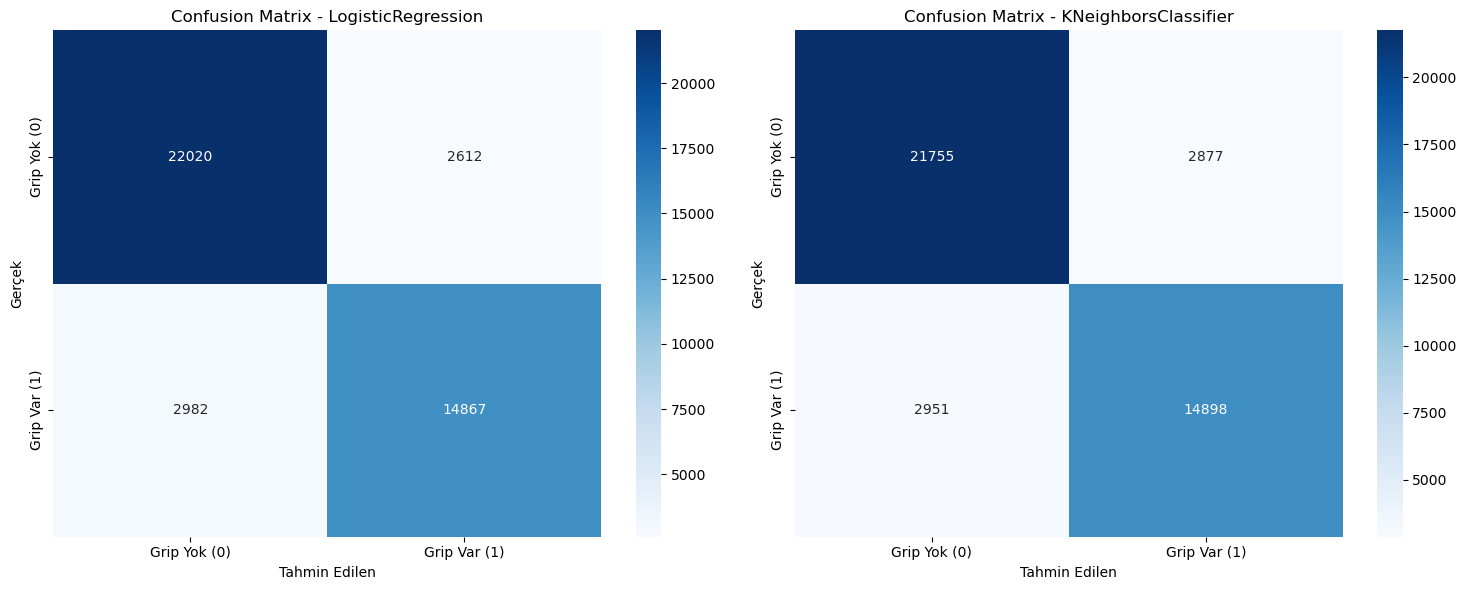

In [79]:
# 7. Base Model Görselleştirmesi
print("\n Base Model Görselleştirmesi")

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for idx, (model_name, results) in enumerate(base_model_results.items()):
    sns.heatmap(results['confusion_matrix'], annot=True, fmt='d', cmap='Blues', 
                ax=axes[idx],
                xticklabels=['Grip Yok (0)', 'Grip Var (1)'], 
                yticklabels=['Grip Yok (0)', 'Grip Var (1)'])
    axes[idx].set_title(f'Confusion Matrix - {model_name}')
    axes[idx].set_xlabel('Tahmin Edilen')
    axes[idx].set_ylabel('Gerçek')

plt.tight_layout()
plt.show()

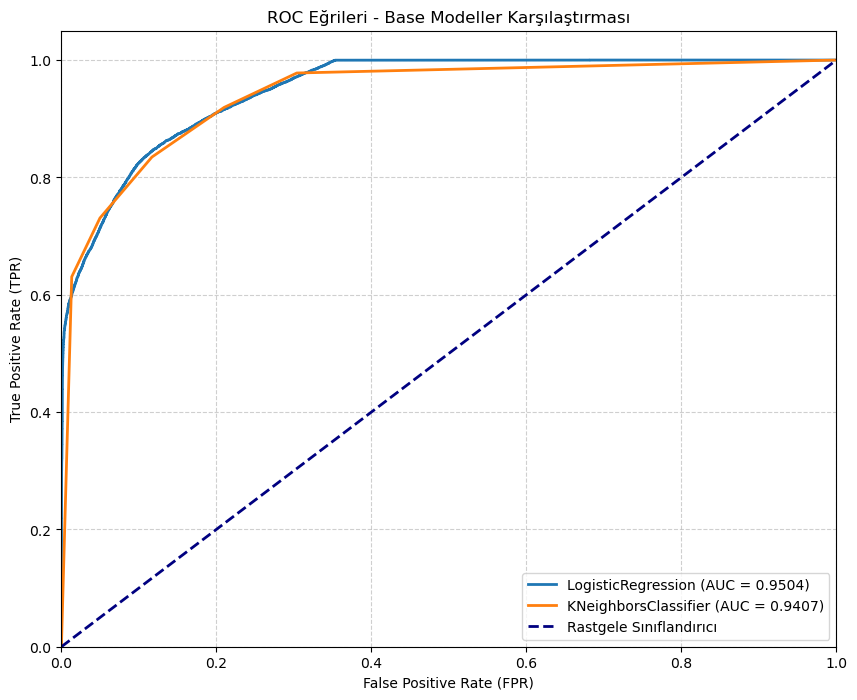

In [80]:
# ROC Eğrileri
plt.figure(figsize=(10, 8))
for model_name, results in base_model_results.items():
    if results['roc_auc'] is not None:
        fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
        plt.plot(fpr, tpr, lw=2, 
                label=f'{model_name} (AUC = {results["roc_auc"]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Sınıflandırıcı')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Eğrileri - Base Modeller Karşılaştırması')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

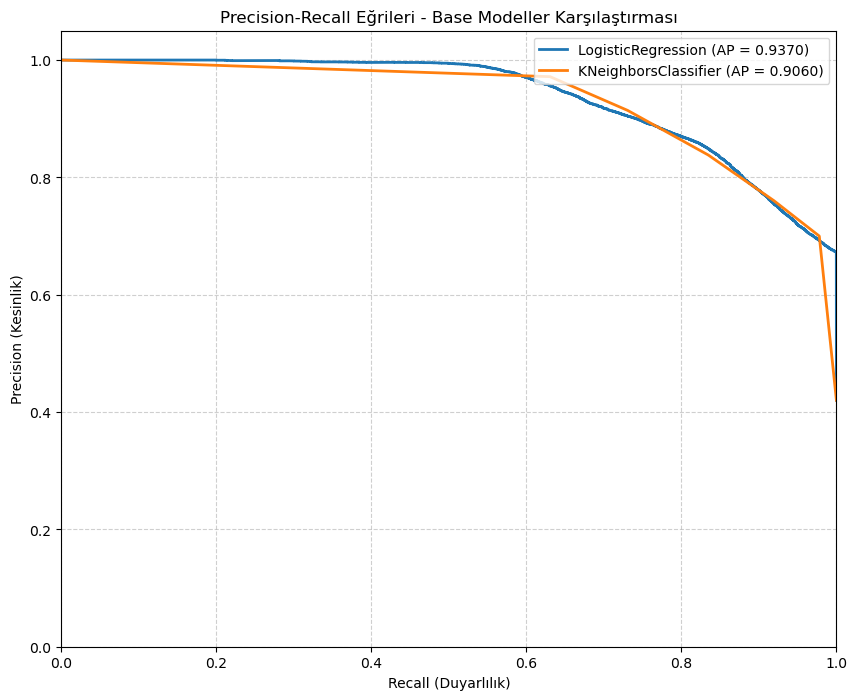

In [81]:
# Precision-Recall Eğrileri
plt.figure(figsize=(10, 8))
for model_name, results in base_model_results.items():
    if results['avg_precision'] is not None:
        precision, recall, _ = precision_recall_curve(y_test, results['y_pred_proba'])
        plt.plot(recall, precision, lw=2,
                label=f'{model_name} (AP = {results["avg_precision"]:.4f})')

plt.xlabel('Recall (Duyarlılık)')
plt.ylabel('Precision (Kesinlik)')
plt.title('Precision-Recall Eğrileri - Base Modeller Karşılaştırması')
plt.legend(loc="upper right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [82]:
# Feature Selection Teknikleri

print("FEATURE SELECTION TEKNİKLERİ VE PERFORMANS KARŞILAŞTIRMASI")

print("\n🔍 Sabit featureların kontrol edilmesi")
constant_features = []
for i in range(X_train_scaled.shape[1]):
    if np.std(X_train_scaled[:, i]) == 0:
        constant_features.append(i)

if constant_features:
    print(f"⚠️  {len(constant_features)} sabit feature bulundu: {constant_features}")
    non_constant_indices = [i for i in range(X_train_scaled.shape[1]) if i not in constant_features]
    X_train_scaled_fs = X_train_scaled[:, non_constant_indices]
    X_test_scaled_fs = X_test_scaled[:, non_constant_indices]
    features_fs = [features[i] for i in non_constant_indices]
    print(f"🔧 Sabit feature'lar çıkarıldı. Yeni feature sayısı: {len(features_fs)}")
else:
    print("Hiç sabit feature bulunamadı.")
    X_train_scaled_fs = X_train_scaled
    X_test_scaled_fs = X_test_scaled
    features_fs = features

FEATURE SELECTION TEKNİKLERİ VE PERFORMANS KARŞILAŞTIRMASI

🔍 Sabit featureların kontrol edilmesi
⚠️  1 sabit feature bulundu: [7]
🔧 Sabit feature'lar çıkarıldı. Yeni feature sayısı: 13


In [83]:
feature_selection_techniques = {
    'SelectKBest (k=8)': SelectKBest(score_func=f_classif, k=min(8, len(features_fs))),
    'RFE (n=8)': RFE(estimator=LogisticRegression(random_state=42), n_features_to_select=min(8, len(features_fs))),
    'SelectFromModel': SelectFromModel(LogisticRegression(random_state=42, penalty='l1', solver='liblinear'), max_features=min(8, len(features_fs)))
}

all_results = []
all_visualization_data = []

print("\n BASELINE: Tüm Featurelar ile Model Performansı")
for model_name, results in base_model_results.items():
    all_results.append({
        'Model': model_name,
        'Technique': 'Baseline (All Features)',
        'Num_Features': len(features_fs),
        'Accuracy': results['accuracy'],
        'ROC_AUC': results['roc_auc'] if results['roc_auc'] else 0,
        'Avg_Precision': results['avg_precision'] if results['avg_precision'] else 0,
        'Type': 'Baseline'
    })
    
    all_visualization_data.append({
        'Model': model_name,
        'Technique': 'Baseline (All Features)',
        'Type': 'Baseline',
        'Confusion_Matrix': results['confusion_matrix'],
        'Y_Pred_Proba': results['y_pred_proba'],
        'ROC_AUC': results['roc_auc'],
        'Avg_Precision': results['avg_precision']
    })


 BASELINE: Tüm Featurelar ile Model Performansı


In [84]:
for fs_name, fs_technique in feature_selection_techniques.items():
    print(f"\n🔧 {fs_name} Uygulanıyor...")
    
    try:
        X_selected = fs_technique.fit_transform(X_train_scaled_fs, y_train)
        
        if hasattr(fs_technique, 'get_support'):
            selected_features_mask = fs_technique.get_support()
        else:
            selected_features_mask = fs_technique.support_
        
        selected_features = [features_fs[i] for i in range(len(features_fs)) if selected_features_mask[i]]
        print(f"   Seçilen {len(selected_features)} feature: {selected_features}")
        
        X_test_selected = fs_technique.transform(X_test_scaled_fs)
        
        for model_name, original_model in base_models.items():
            print(f"   🎯 {model_name} test ediliyor...")
            
            model = clone(original_model)
            model.fit(X_selected, y_train)
            
            y_pred = model.predict(X_test_selected)
            y_pred_proba = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None
            
            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)
            roc_auc = None
            avg_precision = None
            
            if y_pred_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                roc_auc = auc(fpr, tpr)
                avg_precision = average_precision_score(y_test, y_pred_proba)
            
            all_results.append({
                'Model': model_name,
                'Technique': fs_name,
                'Num_Features': len(selected_features),
                'Accuracy': accuracy,
                'ROC_AUC': roc_auc if roc_auc else 0,
                'Avg_Precision': avg_precision if avg_precision else 0,
                'Type': 'Feature Selection'
            })
            
            all_visualization_data.append({
                'Model': model_name,
                'Technique': fs_name,
                'Type': 'Feature Selection',
                'Confusion_Matrix': conf_matrix,
                'Y_Pred_Proba': y_pred_proba,
                'ROC_AUC': roc_auc,
                'Avg_Precision': avg_precision
            })
            
            print(f"      Accuracy: {accuracy:.4f}")
    
    except Exception as e:
        print(f"   ❌ {fs_name} uygulanırken hata: {e}")


🔧 SelectKBest (k=8) Uygulanıyor...
   Seçilen 8 feature: ['collection_month', 'collection_week', 'log_population_served', 'flow_rate_missing', 'log_conc_roll_avg_3', 'log_conc_roll_std_3', 'jurisdiction_positive_count', 'log_pop_sq']
   🎯 LogisticRegression test ediliyor...
      Accuracy: 0.8679
   🎯 KNeighborsClassifier test ediliyor...
      Accuracy: 0.8629

🔧 RFE (n=8) Uygulanıyor...
   Seçilen 8 feature: ['collection_month', 'collection_week', 'log_population_served', 'flow_rate_missing', 'log_conc_roll_avg_3', 'log_conc_roll_std_3', 'log_pop_sq', 'log_flow_sq']
   🎯 LogisticRegression test ediliyor...
      Accuracy: 0.8680
   🎯 KNeighborsClassifier test ediliyor...
      Accuracy: 0.8601

🔧 SelectFromModel Uygulanıyor...
   Seçilen 8 feature: ['collection_month', 'collection_week', 'log_population_served', 'rec_eff_percent', 'flow_rate_missing', 'log_conc_roll_avg_3', 'log_conc_roll_std_3', 'log_pop_sq']
   🎯 LogisticRegression test ediliyor...
      Accuracy: 0.8680
   🎯 KNei

In [85]:
# Dimension Reduction

print("Dimension Reduction Teknikleri ve Performans Karşılaştırması")

dimension_reduction_techniques = {
    'PCA (n=8)': PCA(n_components=min(8, X_train_scaled_fs.shape[1]), random_state=42),
    'LDA': LDA(n_components=1)  # LDA için maksimum n_components = min(n_features, n_classes-1)
}

for dr_name, dr_technique in dimension_reduction_techniques.items():
    print(f"\n🔧 {dr_name} Uygulanıyor...")
    
    try:
        X_reduced = dr_technique.fit_transform(X_train_scaled_fs, y_train)
        
        X_test_reduced = dr_technique.transform(X_test_scaled_fs)
        
        print(f"   Boyut indirgendi: {X_train_scaled_fs.shape[1]} -> {X_reduced.shape[1]}")
        
        for model_name, original_model in base_models.items():
            print(f"   🎯 {model_name} test ediliyor...")
            
            model = clone(original_model)
            model.fit(X_reduced, y_train)
            
            y_pred = model.predict(X_test_reduced)
            y_pred_proba = model.predict_proba(X_test_reduced)[:, 1] if hasattr(model, "predict_proba") else None
            
            accuracy = accuracy_score(y_test, y_pred)
            conf_matrix = confusion_matrix(y_test, y_pred)
            roc_auc = None
            avg_precision = None
            
            if y_pred_proba is not None:
                fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
                roc_auc = auc(fpr, tpr)
                avg_precision = average_precision_score(y_test, y_pred_proba)
            
            all_results.append({
                'Model': model_name,
                'Technique': dr_name,
                'Num_Features': X_reduced.shape[1],
                'Accuracy': accuracy,
                'ROC_AUC': roc_auc if roc_auc else 0,
                'Avg_Precision': avg_precision if avg_precision else 0,
                'Type': 'Dimension Reduction'
            })
            
            all_visualization_data.append({
                'Model': model_name,
                'Technique': dr_name,
                'Type': 'Dimension Reduction',
                'Confusion_Matrix': conf_matrix,
                'Y_Pred_Proba': y_pred_proba,
                'ROC_AUC': roc_auc,
                'Avg_Precision': avg_precision
            })
            
            print(f"      Accuracy: {accuracy:.4f}")
    
    except Exception as e:
        print(f"   ❌ {dr_name} uygulanırken hata: {e}")

Dimension Reduction Teknikleri ve Performans Karşılaştırması

🔧 PCA (n=8) Uygulanıyor...
   Boyut indirgendi: 13 -> 8
   🎯 LogisticRegression test ediliyor...
      Accuracy: 0.8680
   🎯 KNeighborsClassifier test ediliyor...
      Accuracy: 0.8631

🔧 LDA Uygulanıyor...
   Boyut indirgendi: 13 -> 1
   🎯 LogisticRegression test ediliyor...
      Accuracy: 0.8682
   🎯 KNeighborsClassifier test ediliyor...
      Accuracy: 0.8417


In [86]:
results_df = pd.DataFrame(all_results)

# Kapsamlı Performans ve Analiz Tablosu 

print("Kapsamlı Performans Karşılaştırma Tablosu")

print(f"{'Model':<20} {'Teknik':<25} {'Tip':<20} {'# Features':<12} {'Accuracy':<10} {'ROC AUC':<10} {'Avg Precision':<12}")
print("-" * 120)

for _, row in results_df.iterrows():
    print(f"{row['Model']:<20} {row['Technique']:<25} {row['Type']:<20} {row['Num_Features']:<12} {row['Accuracy']:<10.4f} {row['ROC_AUC']:<10.4f} {row['Avg_Precision']:<12.4f}")

Kapsamlı Performans Karşılaştırma Tablosu
Model                Teknik                    Tip                  # Features   Accuracy   ROC AUC    Avg Precision
------------------------------------------------------------------------------------------------------------------------
LogisticRegression   Baseline (All Features)   Baseline             13           0.8683     0.9504     0.9370      
KNeighborsClassifier Baseline (All Features)   Baseline             13           0.8628     0.9407     0.9060      
LogisticRegression   SelectKBest (k=8)         Feature Selection    8            0.8679     0.9504     0.9369      
KNeighborsClassifier SelectKBest (k=8)         Feature Selection    8            0.8629     0.9398     0.9047      
LogisticRegression   RFE (n=8)                 Feature Selection    8            0.8680     0.9504     0.9370      
KNeighborsClassifier RFE (n=8)                 Feature Selection    8            0.8601     0.9385     0.9040      
LogisticRegression   Sel

Tüm tekniklere göre Model karşılaştırması


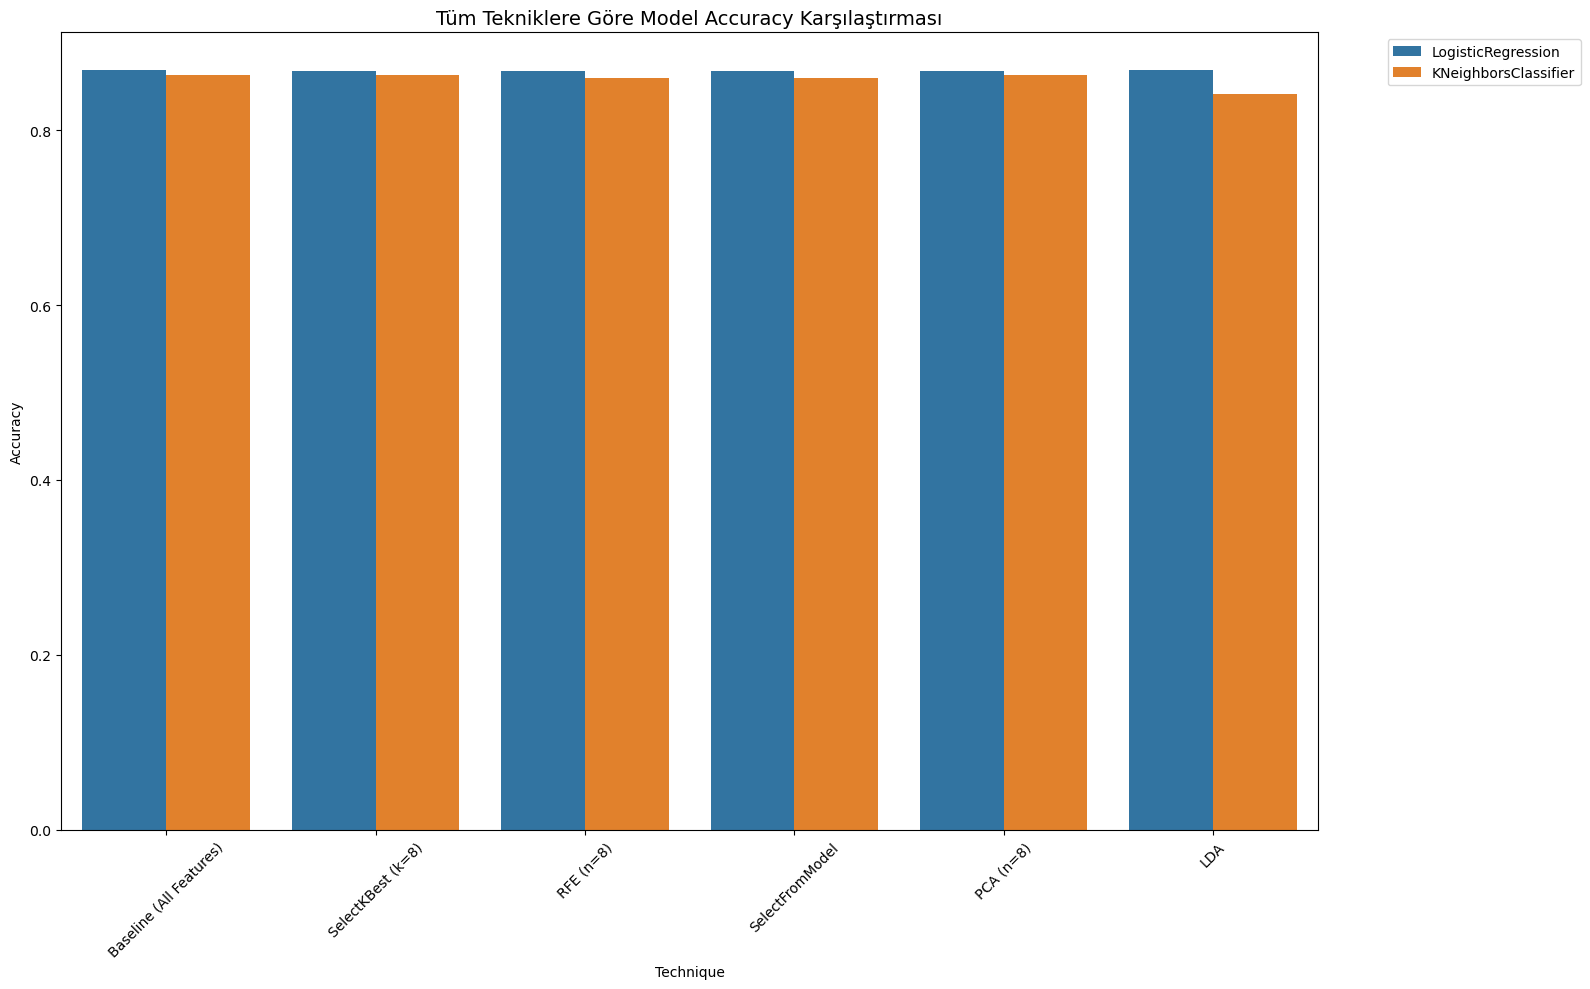

In [87]:
print("Tüm tekniklere göre Model karşılaştırması")

plt.figure(figsize=(16, 10))
sns.barplot(data=results_df, x='Technique', y='Accuracy', hue='Model')
plt.title('Tüm Tekniklere Göre Model Accuracy Karşılaştırması', fontsize=14)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

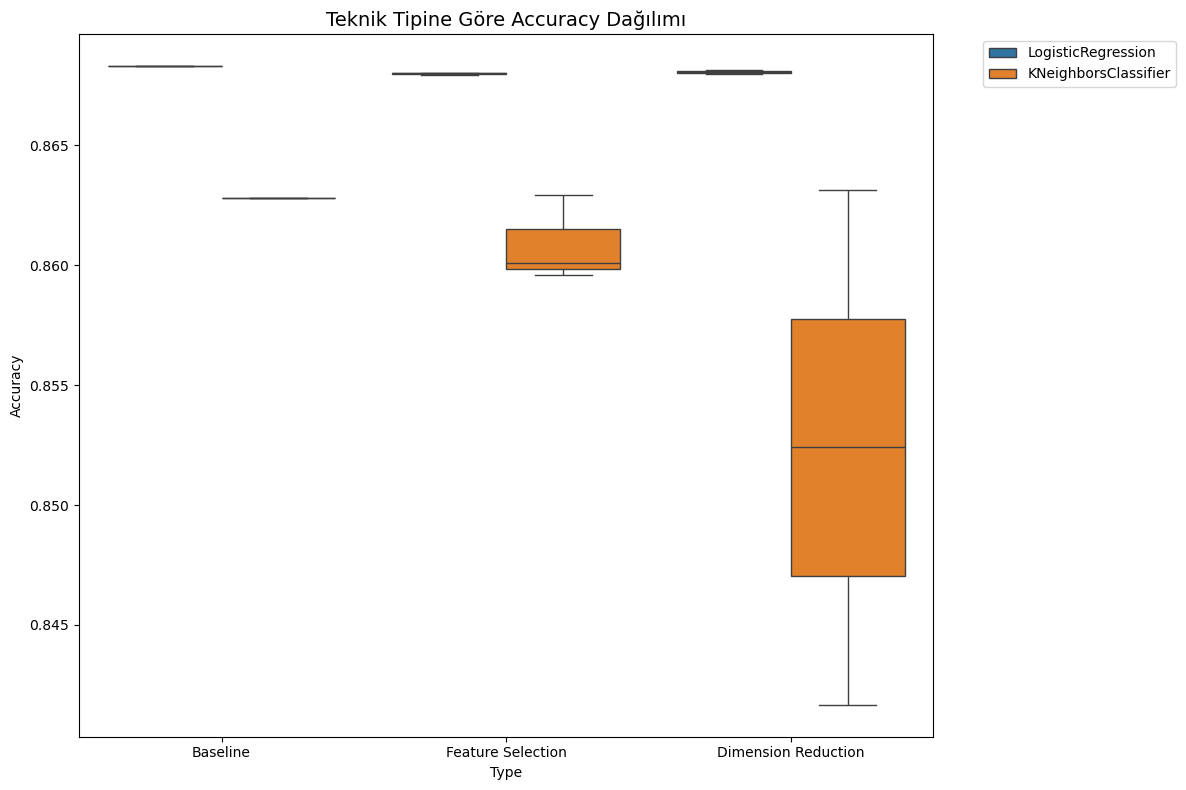

In [88]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=results_df, x='Type', y='Accuracy', hue='Model')
plt.title('Teknik Tipine Göre Accuracy Dağılımı', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

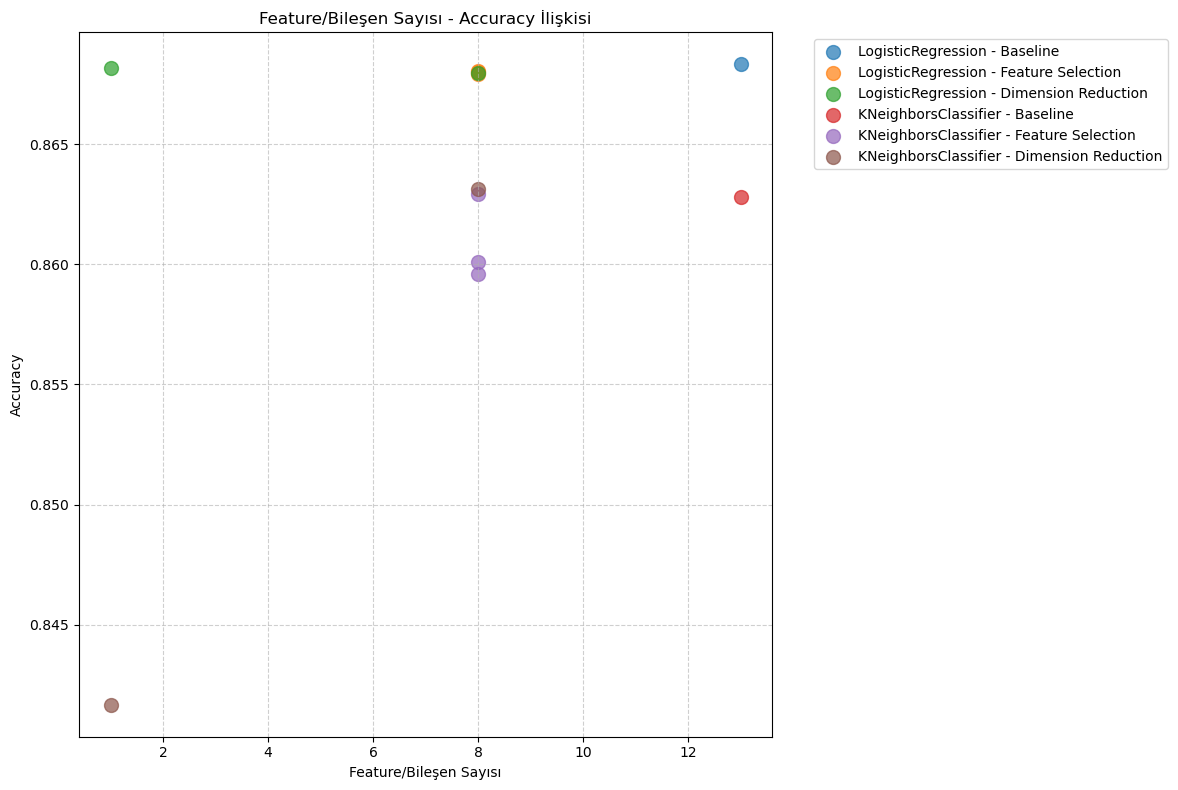

In [89]:
plt.figure(figsize=(12, 8))
for model in results_df['Model'].unique():
    for technique_type in results_df['Type'].unique():
        model_data = results_df[(results_df['Model'] == model) & (results_df['Type'] == technique_type)]
        if not model_data.empty:
            plt.scatter(model_data['Num_Features'], model_data['Accuracy'], 
                       label=f'{model} - {technique_type}', s=100, alpha=0.7)

plt.xlabel('Feature/Bileşen Sayısı')
plt.ylabel('Accuracy')
plt.title('Feature/Bileşen Sayısı - Accuracy İlişkisi')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


 En iyi 3 Teknik için Confusion Matrixler


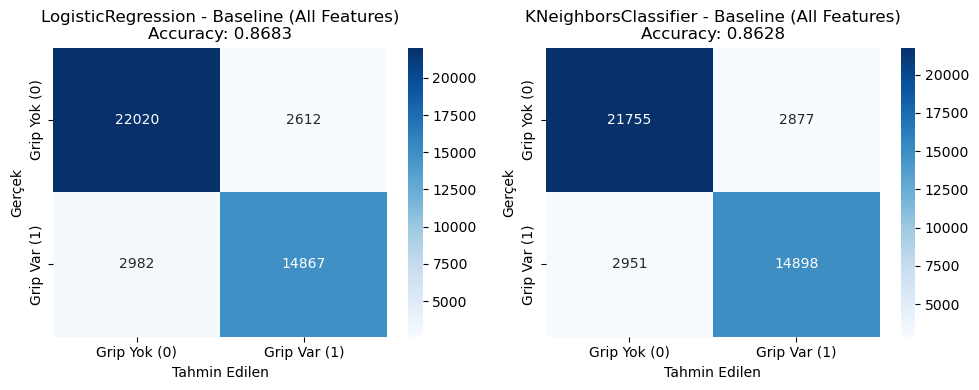

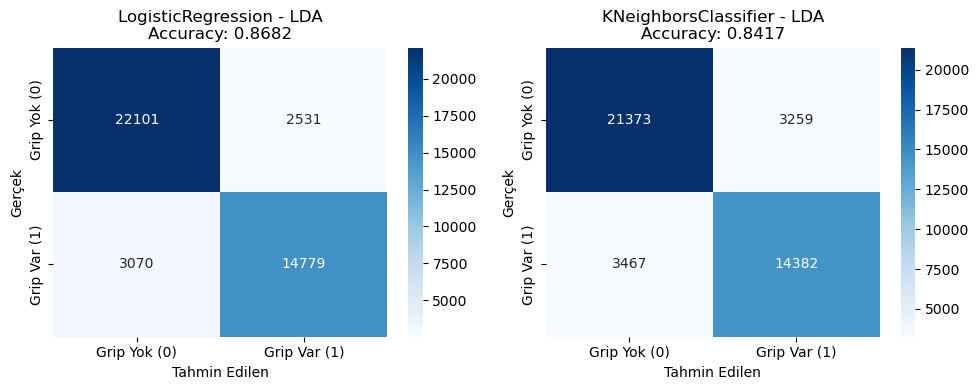

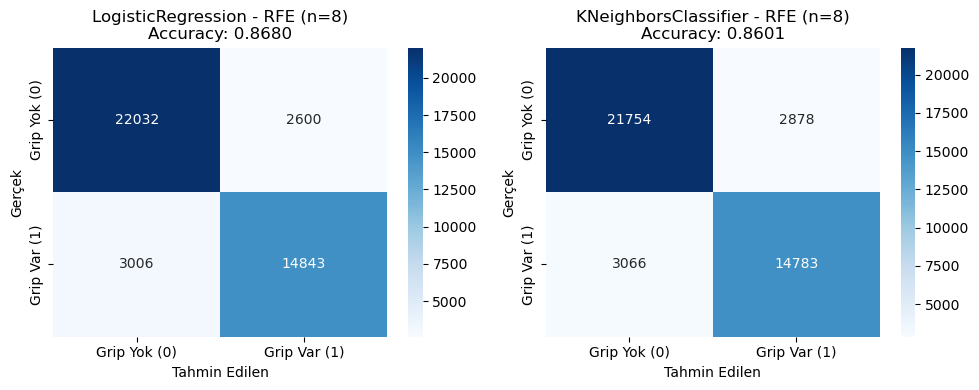

In [90]:
print("\n En iyi 3 Teknik için Confusion Matrixler")

best_3_techniques = results_df.nlargest(3, 'Accuracy')['Technique'].unique()

for technique in best_3_techniques:
    technique_data = [data for data in all_visualization_data if data['Technique'] == technique]
    
    if technique_data:
        fig, axes = plt.subplots(1, len(technique_data), figsize=(5*len(technique_data), 4))
        if len(technique_data) == 1:
            axes = [axes]
        
        for idx, data in enumerate(technique_data):
            sns.heatmap(data['Confusion_Matrix'], annot=True, fmt='d', cmap='Blues', 
                       ax=axes[idx],
                       xticklabels=['Grip Yok (0)', 'Grip Var (1)'], 
                       yticklabels=['Grip Yok (0)', 'Grip Var (1)'])
            axes[idx].set_title(f'{data["Model"]} - {technique}\nAccuracy: {results_df[(results_df["Model"]==data["Model"]) & (results_df["Technique"]==technique)]["Accuracy"].values[0]:.4f}')
            axes[idx].set_xlabel('Tahmin Edilen')
            axes[idx].set_ylabel('Gerçek')
        
        plt.tight_layout()
        plt.show()


 En iyi 3 Teknik için ROC Eğrileri


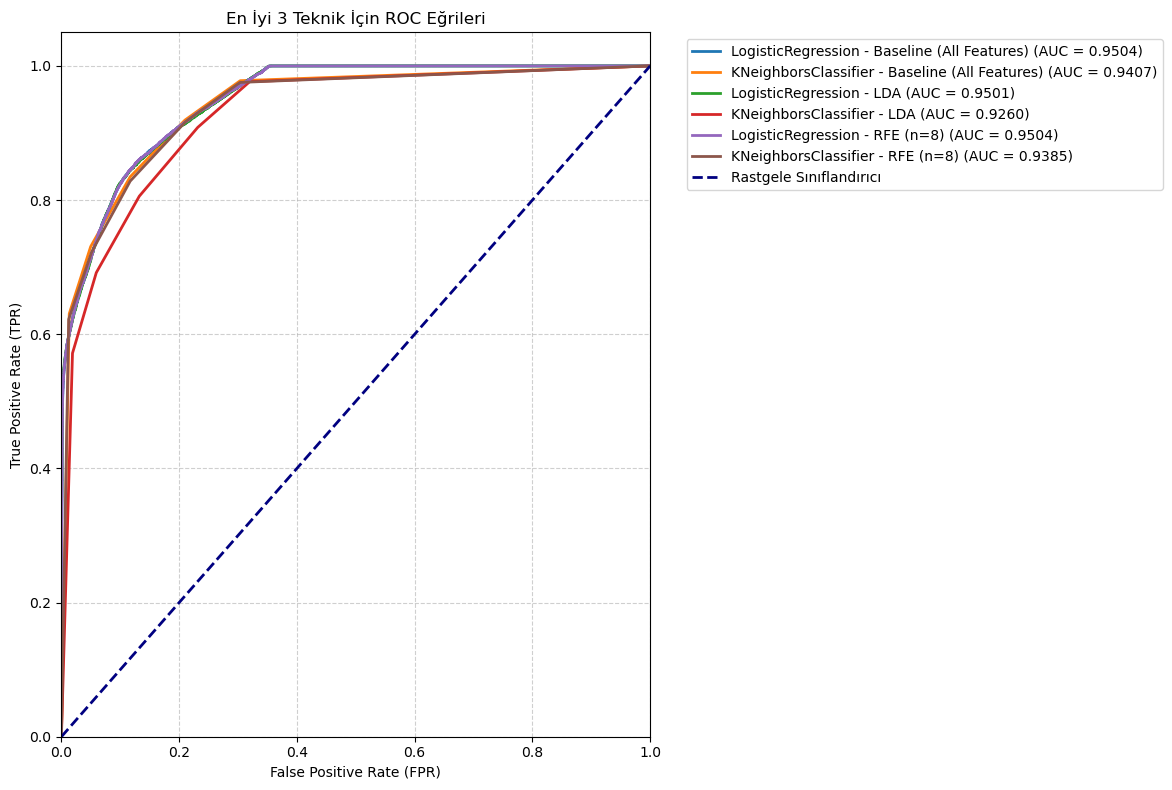

In [91]:
print("\n En iyi 3 Teknik için ROC Eğrileri")

plt.figure(figsize=(12, 8))
for technique in best_3_techniques:
    technique_data = [data for data in all_visualization_data if data['Technique'] == technique and data['Y_Pred_Proba'] is not None]
    
    for data in technique_data:
        fpr, tpr, _ = roc_curve(y_test, data['Y_Pred_Proba'])
        plt.plot(fpr, tpr, lw=2, 
                label=f'{data["Model"]} - {technique} (AUC = {data["ROC_AUC"]:.4f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Sınıflandırıcı')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('En İyi 3 Teknik İçin ROC Eğrileri')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


 En iyi 3 Teknik için PR Eğrileri 


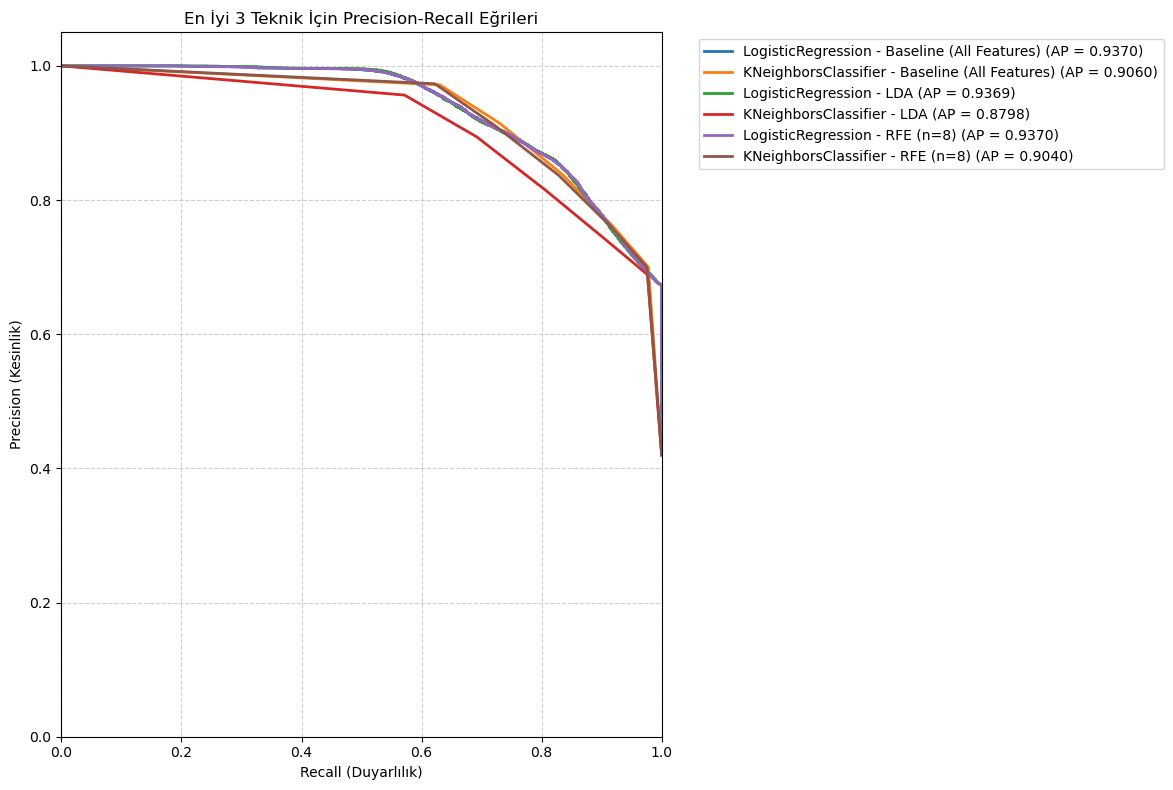

In [92]:
print("\n En iyi 3 Teknik için PR Eğrileri ")

plt.figure(figsize=(12, 8))
for technique in best_3_techniques:
    technique_data = [data for data in all_visualization_data if data['Technique'] == technique and data['Y_Pred_Proba'] is not None]
    
    for data in technique_data:
        precision, recall, _ = precision_recall_curve(y_test, data['Y_Pred_Proba'])
        plt.plot(recall, precision, lw=2,
                label=f'{data["Model"]} - {technique} (AP = {data["Avg_Precision"]:.4f})')

plt.xlabel('Recall (Duyarlılık)')
plt.ylabel('Precision (Kesinlik)')
plt.title('En İyi 3 Teknik İçin Precision-Recall Eğrileri')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tight_layout()
plt.show()

In [93]:
print("En İyi Performans Sonuçları")

best_accuracy = results_df.nlargest(10, 'Accuracy')
print("\n En yüksek Accuracy (Top 10):")
print(best_accuracy[['Model', 'Technique', 'Type', 'Num_Features', 'Accuracy']].to_string(index=False))

if not results_df[results_df['ROC_AUC'] > 0].empty:
    best_roc_auc = results_df[results_df['ROC_AUC'] > 0].nlargest(5, 'ROC_AUC')
    print("\n En yüksek ROC AUC (Top 5):")
    print(best_roc_auc[['Model', 'Technique', 'Type', 'Num_Features', 'ROC_AUC']].to_string(index=False))

En İyi Performans Sonuçları

 En yüksek Accuracy (Top 10):
               Model               Technique                Type  Num_Features  Accuracy
  LogisticRegression Baseline (All Features)            Baseline            13  0.868318
  LogisticRegression                     LDA Dimension Reduction             1  0.868153
  LogisticRegression               RFE (n=8)   Feature Selection             8  0.868035
  LogisticRegression         SelectFromModel   Feature Selection             8  0.868012
  LogisticRegression               PCA (n=8) Dimension Reduction             8  0.867965
  LogisticRegression       SelectKBest (k=8)   Feature Selection             8  0.867917
KNeighborsClassifier               PCA (n=8) Dimension Reduction             8  0.863139
KNeighborsClassifier       SelectKBest (k=8)   Feature Selection             8  0.862927
KNeighborsClassifier Baseline (All Features)            Baseline            13  0.862809
KNeighborsClassifier               RFE (n=8)   Feat

In [94]:
print("\n Teknik tipine göre Ortalama Performans")
type_performance = results_df.groupby('Type').agg({
    'Accuracy': ['mean', 'std', 'max'],
    'ROC_AUC': ['mean', 'std', 'max']
}).round(4)
print(type_performance)

# Model bazında en iyi teknikler
print("\n Model bazında en iyi teknikler: ")
for model in results_df['Model'].unique():
    model_best = results_df[results_df['Model'] == model].nlargest(1, 'Accuracy')
    best_row = model_best.iloc[0]
    print(f"   {model}: {best_row['Technique']} (Accuracy: {best_row['Accuracy']:.4f}, Features: {best_row['Num_Features']})")


 Teknik tipine göre Ortalama Performans
                    Accuracy                 ROC_AUC                
                        mean     std     max    mean     std     max
Type                                                                
Baseline              0.8656  0.0039  0.8683  0.9455  0.0068  0.9504
Dimension Reduction   0.8602  0.0126  0.8682  0.9417  0.0114  0.9503
Feature Selection     0.8644  0.0041  0.8680  0.9444  0.0066  0.9504

 Model bazında en iyi teknikler: 
   LogisticRegression: Baseline (All Features) (Accuracy: 0.8683, Features: 13)
   KNeighborsClassifier: PCA (n=8) (Accuracy: 0.8631, Features: 8)


In [96]:
print("Sınıflandırma Raporu")

from sklearn.metrics import classification_report

print("\n Gerçek sınıflandırma metrikleri:\n")

for model_name, results in base_model_results.items():
    
    print(f"MODEL: {model_name} - Baseline")
    
    y_true = y_test
    y_pred = results['y_pred']
    
    print(classification_report(y_true, y_pred, 
                               target_names=['Grip Yok (0)', 'Grip Var (1)'],
                               digits=4))
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    print(f"Confusion Matrix:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print()

print("Feature selection ve dimension reduction sonuçları")

best_techniques = results_df.nlargest(3, 'Accuracy')

for _, row in best_techniques.iterrows():
    if row['Technique'] != 'Baseline (All Features)':

        print(f"{row['Model']} - {row['Technique']}")

        print(f"Accuracy: {row['Accuracy']:.4f}")
        print(f"ROC AUC: {row['ROC_AUC']:.4f}" if not pd.isna(row['ROC_AUC']) else "ROC AUC: N/A")
        print()

print("Özet performans tablosu")

print(f"\n{'Model':<25} {'Teknik':<30} {'Accuracy':<10} {'ROC AUC':<10}")


for _, row in results_df.iterrows():
    roc_auc_str = f"{row['ROC_AUC']:.4f}" if not pd.isna(row['ROC_AUC']) else "N/A"
    print(f"{row['Model']:<25} {row['Technique']:<30} {row['Accuracy']:<10.4f} {roc_auc_str:<10}")

print("En iyi performans sonuçları")

if not results_df.empty:
    best_accuracy = results_df.loc[results_df['Accuracy'].idxmax()]
    print(f"\n En Yüksek Accuracy:")
    print(f"   Model: {best_accuracy['Model']}")
    print(f"   Teknik: {best_accuracy['Technique']}")
    print(f"   Accuracy: {best_accuracy['Accuracy']:.4f}")
    print(f"   ROC AUC: {best_accuracy['ROC_AUC']:.4f}" if not pd.isna(best_accuracy['ROC_AUC']) else "   ROC AUC: N/A")


print("Model Karşılaştırması")

model_comparison = results_df.groupby('Model').agg({
    'Accuracy': ['mean', 'max', 'min'],
    'ROC_AUC': 'mean'
}).round(4)

print(f"\n{'Model':<25} {'Ort. Accuracy':<12} {'Max Accuracy':<12} {'Min Accuracy':<12} {'Ort. ROC AUC':<12}")


for model in model_comparison.index:
    acc_mean = model_comparison.loc[model, ('Accuracy', 'mean')]
    acc_max = model_comparison.loc[model, ('Accuracy', 'max')]
    acc_min = model_comparison.loc[model, ('Accuracy', 'min')]
    roc_mean = model_comparison.loc[model, ('ROC_AUC', 'mean')] if not pd.isna(model_comparison.loc[model, ('ROC_AUC', 'mean')]) else 0
    
    print(f"{model:<25} {acc_mean:<12.4f} {acc_max:<12.4f} {acc_min:<12.4f} {roc_mean:<12.4f}")


Sınıflandırma Raporu

 Gerçek sınıflandırma metrikleri:

MODEL: LogisticRegression - Baseline
              precision    recall  f1-score   support

Grip Yok (0)     0.8807    0.8940    0.8873     24632
Grip Var (1)     0.8506    0.8329    0.8417     17849

    accuracy                         0.8683     42481
   macro avg     0.8656    0.8634    0.8645     42481
weighted avg     0.8681    0.8683    0.8681     42481

Confusion Matrix:
TN: 22020, FP: 2612, FN: 2982, TP: 14867
Accuracy: 0.8683

MODEL: KNeighborsClassifier - Baseline
              precision    recall  f1-score   support

Grip Yok (0)     0.8806    0.8832    0.8819     24632
Grip Var (1)     0.8381    0.8347    0.8364     17849

    accuracy                         0.8628     42481
   macro avg     0.8593    0.8589    0.8591     42481
weighted avg     0.8627    0.8628    0.8628     42481

Confusion Matrix:
TN: 21755, FP: 2877, FN: 2951, TP: 14898
Accuracy: 0.8628

Feature selection ve dimension reduction sonuçları
Logistic